c:\program files (x86)\python37-32\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated


[[Fit Statistics]]
    # fitting method   = differential_evolution
    # function evals   = 4704
    # data points      = 1
    # variables        = 8
    chi-square         = 1.4432e+11
    reduced chi-square = 1.4432e+11
    Akaike info crit   = 41.6952700
    Bayesian info crit = 25.6952700
##  Warning: uncertainties could not be estimated:
    b:     at boundary
[[Variables]]
    b:     1.00000000 (init = 0.5)
    x5:    0.01829493 (init = 0.5)
    x6:    0.13842475 (init = 0.5)
    x7:    0.00958946 (init = 0.5)
    psi3:  0.05258904 (init = 0.5)
    psi5:  0.01615950 (init = 0.5)
    psi6:  0.23096656 (init = 0.5)
    psi7:  0.26916991 (init = 0.5)
Original beta = .871, My beta =  1.0
Original x5   = .724, My x5   =  0.01829493470987
Original x6   = 1.38, My x6   =  0.138424751064234
Original x7   = .107, My x7   =  0.009589458634211446
Original psi3 = .083, My psi3 =  0.05258904095061873
Original psi5 = .018, My psi5 =  0.016159503090044942
Original psi6 = .233, My psi6 =  0.230

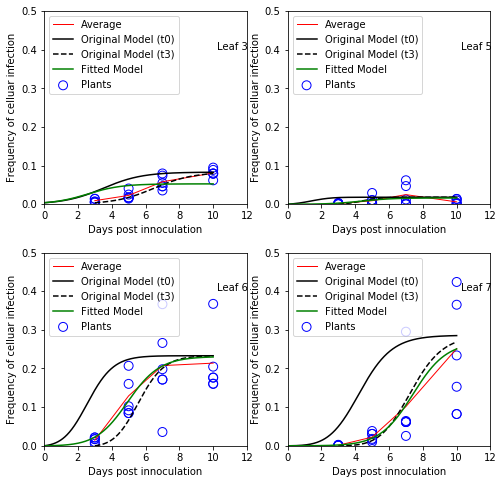

In [3]:
import pandas as pd
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import curve_fit
from lmfit import minimize, Parameters, Parameter, report_fit
import matplotlib.pyplot as plt
import os
#==============================================================================
''' Make new data matrix, same as csv except infected cells are one total for convience '''
DataFrame = pd.read_csv('Cell_count_data_Tromas_2014.csv') # Read data from file

TROMAS_DATA = np.empty((DataFrame.shape[0], 5), int)
for i in range(DataFrame.shape[0]): # Number of rows
    for j in range(5):              # Number of columns desired
        TROMAS_DATA[i][j] = DataFrame.iloc[i, j]
        if j == 4:
            TROMAS_DATA[i][j] = DataFrame.ix[i, 'Venus_only'] + DataFrame.ix[i, 'BFP_only'] + DataFrame.ix[i, 'Mixed']
'''
Col 0: Days post infection
Col 1: Leaf number
Col 2: Replicate plant number
Col 3: Number of unifected cells
Col 4: Number of total infected cells
'''
#==============================================================================
''' Create subplot array '''
fig, ax = plt.subplots(2, 2, figsize = (8, 8))
fig.subplots_adjust(hspace = .25, wspace = .2)
#==============================================================================
''' Make axis for data points '''
DAYS_AXIS = [3, 5, 7, 10]
#==============================================================================
''' Make axis for negative log likelihood '''
ZERO_DAYS_AXIS = [0, 3, 5, 7, 10]
#==============================================================================
''' Time axis for models '''
t = np.linspace(0, 10, 1000)
#==============================================================================
''' Time axis for models '''
t3 = np.linspace(3, 10, 1000)
#==============================================================================
''' Parameter list (All initialized with guesses) '''
parameters = Parameters()
parameters.add('b', value = .5, min = .0001, max = 1.0000)
parameters.add('x5', value = .5, min = .0001, max = 2.0000)
parameters.add('x6', value = .5, min = .0001, max = 2.0000)
parameters.add('x7', value = .5, min = .0001, max = 2.0000)
parameters.add('psi3', value = .5, min = .0001, max = 1.0000)
parameters.add('psi5', value = .5, min = .0001, max = 1.0000)
parameters.add('psi6', value = .5, min = .0001, max = 1.0000)
parameters.add('psi7', value = .5, min = .0001, max = 1.0000)
#==============================================================================
'''  Initial conditions '''
I0 = 3.72 * 10**-3
Ik0 = [I0, 0, 0, 0]
#==============================================================================
''' Define the model, Eq. (1) on pg. 3 '''
def original(Ik, t):
    I0 = 3.72 * 10**-3  # Original 3.72 * 10**-3
    b = .871            # Original .871
    x5 = .724           # Original .724
    x6 = 1.38           # Original 1.38
    x7 = .107           # Original .107
    psi3 = .083         # Original .083
    psi5 = .018         # Original .018
    psi6 = .233         # Original .233
    psi7 = .286         # Original .286

    I3 = Ik[0]
    I5 = Ik[1]
    I6 = Ik[2]
    I7 = Ik[3]

    if (I3 < psi3):
        S3 = (1 - (I3 / psi3))
    else:
        S3 = 0
    if (I5 < psi5):
        S5 = (1 - (I5 / psi5))
    else:
        S5 = 0
    if (I6 < psi6):
        S6 = (1 - (I6 / psi6))
    else:
        S6 = 0
    if (I7 < psi7):
        S7 = (1 - (I7 / psi7))
    else:
        S7 = 0

    dI3dt = b * I3 * S3
    dI5dt = b * I5 * S5 + x5 * S5 * I3
    dI6dt = b * I6 * S6 + x6 * S6 * (I3 + I5)
    dI7dt = b * I7 * S7 + x7 * S7 * (I3 + I5 + I6)

    return [dI3dt, dI5dt, dI6dt, dI7dt]
#==============================================================================
def model(Mk, t, parameters):
    M3 = Mk[0]
    M5 = Mk[1]
    M6 = Mk[2]
    M7 = Mk[3]

    try: # Get parameters
        b = parameters['b'].value
        x5 = parameters['x5'].value
        x6 = parameters['x6'].value
        x7 = parameters['x7'].value
        psi3 = parameters['psi3'].value
        psi5 = parameters['psi5'].value
        psi6 = parameters['psi6'].value
        psi7 = parameters['psi7'].value
    except KeyError:
        b, x5, x6, x7, psi3, psi5, psi6, psi7 = parameters

    if (M3 < psi3):
        S3 = (1 - (M3 / psi3))
    else:
        S3 = 0
    if (M5 < psi5):
        S5 = (1 - (M5 / psi5))
    else:
        S5 = 0
    if (M6 < psi6):
        S6 = (1 - (M6 / psi6))
    else:
        S6 = 0
    if (M7 < psi7):
        S7 = (1 - (M7 / psi7))
    else:
        S7 = 0

    dM3dt = b * M3 * S3
    dM5dt = b * M5 * S5 + x5 * S5 * M3
    dM6dt = b * M6 * S6 + x6 * S6 * (M3 + M5)
    dM7dt = b * M7 * S7 + x7 * S7 * (M3 + M5 + M6)

    return [dM3dt, dM5dt, dM6dt, dM7dt]
#==============================================================================
''' Compute negative log likelihood of Tromas' data given the model, see eq. (3) pg. 11 '''
def negLogLike(parameters):
    # Solve ODE system to get model values; parameters are not yet fitted
    MM = odeint(model, Ik0, ZERO_DAYS_AXIS, args=(parameters,))
    M3 = MM[:, 0]
    M5 = MM[:, 1]
    M6 = MM[:, 2]
    M7 = MM[:, 3]

    nll = 0;
    for t in range(4):          # Iterate through days
        for p in range(5):      # Iterate through replicates
            for k in range(4):  # Iterate through leaves
                Vktp = TROMAS_DATA[20 * t + 4 * p + k][4]          # Number of infected cells
                Aktp = TROMAS_DATA[20 * t + 4 * p + k][3] + Vktp   # Total number of cells observed
                Iktp = MM[t + 1][k]                                # Frequency of cellular infection

                nll += Vktp * np.log(Iktp) + (Aktp - Vktp) * np.log(1 - Iktp)
    
    return [-nll]
#==============================================================================
''' Miminize negative log likelihood '''
result = minimize(negLogLike, parameters, method = 'differential_evolution')
#==============================================================================
''' Solve original system of differential equations '''
II = odeint(original, Ik0, t)
I3 = II[:, 0]
I5 = II[:, 1]
I6 = II[:, 2]
I7 = II[:, 3]
#==============================================================================
''' Solve original system of differential equations with t = 3 '''
II_3 = odeint(original, Ik0, t3)
I3_3 = II_3[:, 0]
I5_3 = II_3[:, 1]
I6_3 = II_3[:, 2]
I7_3 = II_3[:, 3]
#==============================================================================
''' Compare fitted values with those in Tromas' paper '''
print("======================================================================")
print("======================================================================")
report_fit(result)
print("======================================================================")
print("======================================================================")
print("Original beta = .871, My beta = ", result.params['b'].value)
print("Original x5   = .724, My x5   = ", result.params['x5'].value)
print("Original x6   = 1.38, My x6   = ", result.params['x6'].value)
print("Original x7   = .107, My x7   = ", result.params['x7'].value)
print("Original psi3 = .083, My psi3 = ", result.params['psi3'].value)
print("Original psi5 = .018, My psi5 = ", result.params['psi5'].value)
print("Original psi6 = .233, My psi6 = ", result.params['psi6'].value)
print("Original psi7 = .286, My psi7 = ", result.params['psi7'].value)
#==============================================================================
''' Solve ODE system with fitted model parameters '''
FITTED_MM = odeint(model, Ik0, t, args=(result.params,))
FITTED_M3 = FITTED_MM[:, 0]
FITTED_M5 = FITTED_MM[:, 1]
FITTED_M6 = FITTED_MM[:, 2]
FITTED_M7 = FITTED_MM[:, 3]
#==============================================================================
''' Plot experimental data and model curves '''
for leaf_iterator in range(4):
#==============================================================================
    ''' Set up matricies '''
    RATIOS = []
    LEAF_DATA = np.empty((5, 4), float)  # Set up matrix
    AVERAGES = []
    #==========================================================================
    ''' Compute data from csv '''
    for i in range(round(len(TROMAS_DATA) / 4)):  # Iterate through all rows
        non_infected = TROMAS_DATA[(4 * i + leaf_iterator)][3]
        infected = TROMAS_DATA[(4 * i + leaf_iterator)][4]
        ratio = infected / (non_infected + infected)
        RATIOS.append(ratio)
    #==========================================================================
    ''' Build a matrix of ratios with each row being a replicate '''
    for i in range(5):
        for j in range(4):
            LEAF_DATA[i][j] = RATIOS[i + 5 * j]
    #==========================================================================
    ''' Calculate average cellular infection per day '''
    for i in range(4):
        sum = 0
        for j in range(5):
            sum += LEAF_DATA[j][i]
            mean = sum / 5
        AVERAGES.append(mean)
    #==========================================================================
    ''' Plot results '''
    if leaf_iterator == 0:
        for i in range(5):
            ax[0][0].scatter(DAYS_AXIS, LEAF_DATA[i, :], s = 80, facecolors = 'none', edgecolors = 'b')
        ax[0][0].scatter(DAYS_AXIS, LEAF_DATA[0, :], s = 80, facecolors = 'none', edgecolors = 'b', label = "Plants") # Plot copy to get one label
        ax[0][0].plot(DAYS_AXIS, AVERAGES, 'r-', label = "Average", linewidth = 1)

        ax[0][0].plot(t, I3, color = 'black', label = "Original Model (t0)")   # Plot differential equation
        ax[0][0].plot(t3, I3_3, color = 'black', linestyle = 'dashed', label = "Original Model (t3)")
        ax[0][0].plot(t, FITTED_M3, color = 'green', label = "Fitted Model")

        ax[0][0].legend(loc = "upper left")
        ax[0][0].set_xlim(0, 12)
        ax[0][0].set_ylim(0, .5)
        ax[0][0].set_xlabel('Days post innoculation')
        ax[0][0].set_ylabel('Frequency of celluar infection')
        ax[0][0].text(10.25, .4, 'Leaf 3')

    elif leaf_iterator == 1:
        for i in range(5):
            ax[0][1].scatter(DAYS_AXIS, LEAF_DATA[i, :], s = 80, facecolors = 'none', edgecolors = 'b')
        ax[0][1].scatter(DAYS_AXIS, LEAF_DATA[0, :], s = 80, facecolors = 'none', edgecolors = 'b', label = "Plants") # Plot copy to get one label
        ax[0][1].plot(DAYS_AXIS, AVERAGES, 'r-', label = "Average", linewidth = 1)

        ax[0][1].plot(t, I5, color = 'black', label = "Original Model (t0)")   # Plot differential equation
        ax[0][1].plot(t3, I5_3, color = 'black', linestyle = 'dashed', label = "Original Model (t3)")
        ax[0][1].plot(t, FITTED_M5, color = 'green', label = "Fitted Model")

        ax[0][1].legend(loc = "upper left")
        ax[0][1].set_xlim(0, 12)
        ax[0][1].set_ylim(0, .5)
        ax[0][1].set_xlabel('Days post innoculation')
        ax[0][1].set_ylabel('Frequency of celluar infection')
        ax[0][1].text(10.25, .4, 'Leaf 5')

    elif leaf_iterator == 2:
        for i in range(5):
            ax[1][0].scatter(DAYS_AXIS, LEAF_DATA[i, :], s = 80, facecolors = 'none', edgecolors = 'b')
        ax[1][0].scatter(DAYS_AXIS, LEAF_DATA[0, :], s = 80, facecolors = 'none', edgecolors = 'b', label = "Plants") # Plot copy to get one label
        ax[1][0].plot(DAYS_AXIS, AVERAGES, 'r-', label = "Average", linewidth = 1)

        ax[1][0].plot(t, I6, color = 'black', label = "Original Model (t0)")   # Plot differential equation
        ax[1][0].plot(t3, I6_3, color = 'black', linestyle = 'dashed', label = "Original Model (t3)")
        ax[1][0].plot(t, FITTED_M6, color = 'green', label = "Fitted Model")

        ax[1][0].legend(loc = "upper left")
        ax[1][0].set_xlim(0, 12)
        ax[1][0].set_ylim(0, .5)
        ax[1][0].set_xlabel('Days post innoculation')
        ax[1][0].set_ylabel('Frequency of celluar infection')
        ax[1][0].text(10.25, .4, 'Leaf 6')

    elif leaf_iterator == 3:
        for i in range(5):
            ax[1][1].scatter(DAYS_AXIS, LEAF_DATA[i, :], s = 80, facecolors = 'none', edgecolors = 'b')
        ax[1][1].scatter(DAYS_AXIS, LEAF_DATA[0, :], s = 80, facecolors = 'none', edgecolors = 'b', label = "Plants") # Plot copy to get one label
        ax[1][1].plot(DAYS_AXIS, AVERAGES, 'r-', label = "Average", linewidth = 1)

        ax[1][1].plot(t, I7, color = 'black', label = "Original Model (t0)")   # Plot differential equation
        ax[1][1].plot(t3, I7_3, color = 'black', linestyle = 'dashed', label = "Original Model (t3)")
        ax[1][1].plot(t, FITTED_M7, color = 'green', label = "Fitted Model")

        ax[1][1].legend(loc = "upper left")
        ax[1][1].set_xlim(0, 12)
        ax[1][1].set_ylim(0, .5)
        ax[1][1].set_xlabel('Days post innoculation')
        ax[1][1].set_ylabel('Frequency of celluar infection')
        ax[1][1].text(10.25, .4, 'Leaf 7')
#==============================================================================
plt.show()
plt.show()
#==============================================================================